In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import warnings
warnings.filterwarnings('ignore')

In [54]:
feature_extraction_algo = 'sift'
feature_to_match = 'bf'
output_image_name = 'output.jpg'

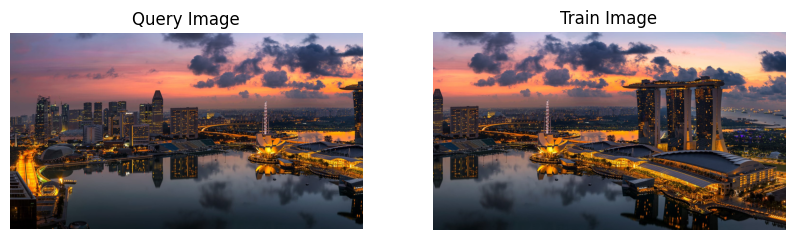

In [42]:
train_image = cv2.imread('Images/train.jpg')
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_RGB2GRAY)

query_image = cv2.imread('Images/query.jpg')
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
query_image_gray = cv2.cvtColor(query_image, cv2.COLOR_RGB2GRAY)


fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = False, figsize=(10, 5))
ax1.imshow(query_image)
ax1.set_title('Query Image')
ax1.axis('off')
ax2.imshow(train_image)
ax2.set_title('Train Image')
ax2.axis('off')
plt.show()




In [43]:
def select_descriptor_extractor(image, algo=None):
    assert algo is not None, "Feature extraction algorithm must be specified."
    assert algo in ['sift', 'surf', 'orb', 'akaze'], "Unsupported feature extraction algorithm: {}".format(algo)
    if algo == 'sift':
        extractor = cv2.SIFT_create()
    elif algo == 'surf':
        extractor = cv2.SURF_create()
    elif algo == 'orb':
        extractor = cv2.ORB_create()
    elif algo == 'akaze':
        extractor = cv2.AKAZE_create()
    else:
        raise ValueError("Unsupported feature extraction algorithm: {}".format(algo))
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return keypoints, descriptors

In [44]:
keypoints_train, descriptors_train = select_descriptor_extractor(train_image_gray, feature_extraction_algo)
keypoints_query, descriptors_query = select_descriptor_extractor(query_image_gray, feature_extraction_algo)

print("Number of keypoints in train image: {}".format(len(keypoints_train)))
print("Number of keypoints in query image: {}".format(len(keypoints_query)))

print("coordinates of the first keypoint in train image: {}".format(keypoints_train[0].pt))
print("size: {}".format(keypoints_train[0].size))
print("angle: {}".format(keypoints_train[0].angle))
print("response: {}".format(keypoints_train[0].response))
print("octave: {}".format(keypoints_train[0].octave))
print("class_id: {}".format(keypoints_train[0].class_id))



Number of keypoints in train image: 6086
Number of keypoints in query image: 4922
coordinates of the first keypoint in train image: (2.927109479904175, 585.1963500976562)
size: 2.018578290939331
angle: 201.94900512695312
response: 0.01925623044371605
octave: 8454655
class_id: -1


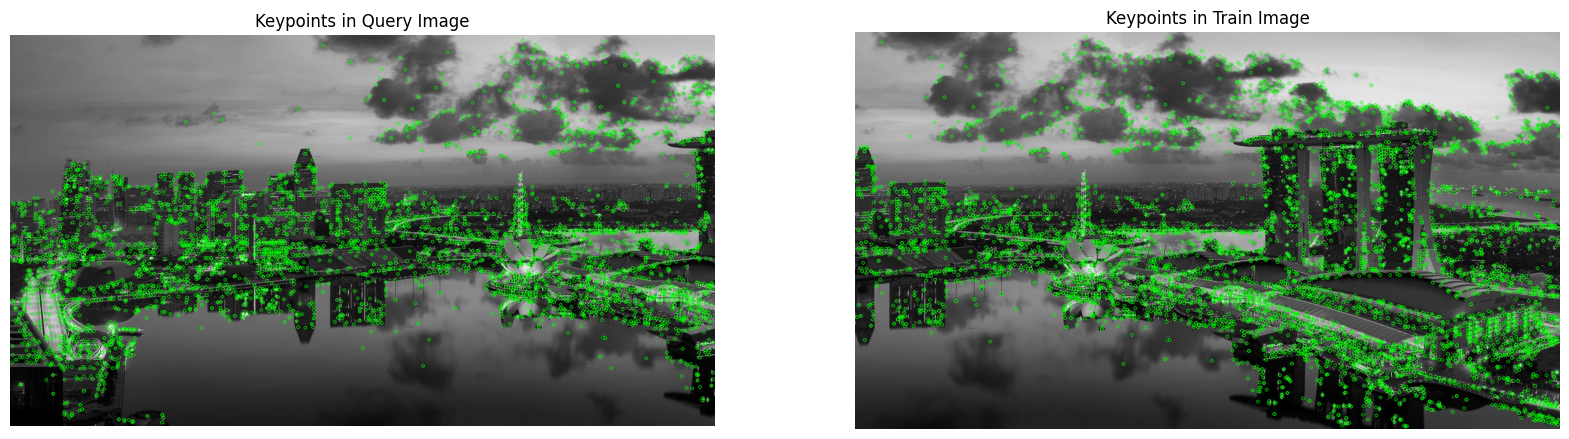

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = False, figsize=(20, 10))
ax1.imshow(cv2.drawKeypoints(query_image_gray, keypoints_query, None, color = (0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT))
ax1.set_title('Keypoints in Query Image')
ax1.axis('off')
ax2.imshow(cv2.drawKeypoints(train_image_gray, keypoints_train, None, color = (0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT))
ax2.set_title('Keypoints in Train Image')
ax2.axis('off')
plt.show()

In [46]:
def select_feature_matcher(method, crossCheck):
    if method == 'sift' or method == 'surf':
        if crossCheck:
            matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        else:
            matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    elif method == 'orb' or method == 'akaze':
        if crossCheck:
            matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        else:
            matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    else:
        raise ValueError("Unsupported feature matching method: {}".format(method))
    return matcher

In [47]:
def keypoint_matching_brute(descriptors_train, descriptors_query, method):
    bf = select_feature_matcher(method, crossCheck=True)
    raw_matches = bf.match(descriptors_train, descriptors_query)
    best_matches = sorted(raw_matches, key=lambda x: x.distance)
    print("Number of matches found (Brute Force): {}".format(len(best_matches)))
    return best_matches

In [48]:
def keypoint_matching_knn(descriptors_train, descriptors_query, ratio, method):
    bf = select_feature_matcher(method, crossCheck=False)
    raw_matches = bf.knnmatch(descriptors_train, descriptors_query, k=2)
    best_matches = []
    for m, n in raw_matches:
        if m.distance < ratio * n.distance:
            best_matches.append(m)
    print("Number of matches found (KNN): {}".format(len(best_matches)))
    return best_matches

Matching keypoints... bf
Number of matches found (Brute Force): 2696


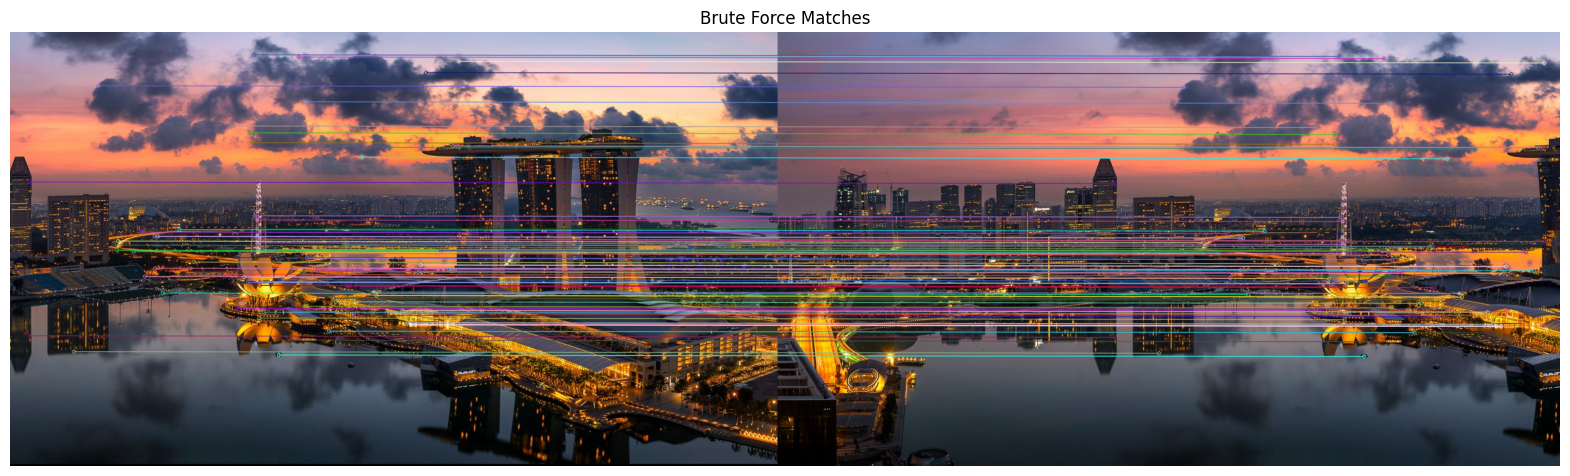

In [49]:
print("Matching keypoints...",feature_to_match)

fig = plt.figure(figsize=(20, 10))
if feature_to_match == 'bf':
    best_matches = keypoint_matching_brute(descriptors_train, descriptors_query, feature_extraction_algo)
    mapped_image = cv2.drawMatches(train_image, keypoints_train, query_image, keypoints_query, best_matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(mapped_image)
    plt.title('Brute Force Matches')
    plt.axis('off')
elif feature_to_match == 'knn':
    best_matches = keypoint_matching_knn(descriptors_train, descriptors_query, 0.75, feature_extraction_algo)
    mapped_image = cv2.drawMatches(train_image, keypoints_train, query_image, keypoints_query, np.random.choice(best_matches, 100), None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(mapped_image)
    plt.title('KNN Matches')
    plt.axis('off')
else:
    raise ValueError("Unsupported feature matching method: {}".format(feature_to_match))
plt.show()


In [50]:
def homography_stitching(keypoints_train, keypoints_query, best_matches, reprojThresh):
    keypoints_train = np.float32([keypoint.pt for keypoint in keypoints_train])
    keypoints_query = np.float32([keypoint.pt for keypoint in keypoints_query])
    if len(best_matches) < 4:
        raise ValueError("Not enough matches found to compute homography.")
    
    if len(best_matches) > 4:
        points_train = np.float32([keypoints_train[m.queryIdx] for m in best_matches])
        points_query = np.float32([keypoints_query[m.trainIdx] for m in best_matches])
    
    (H, status) = cv2.findHomography(points_train, points_query, cv2.RANSAC, reprojThresh)
    return (H, status)


In [51]:
M = homography_stitching(keypoints_train, keypoints_query, best_matches, reprojThresh=4.0)

if M is None:
    raise ValueError("Homography could not be computed. Not enough matches or poor quality matches.")
(Homography_matrix, status) = M
print("Homography matrix:\n", Homography_matrix)

Homography matrix:
 [[ 9.99989878e-01 -1.36886133e-04  5.99046938e+02]
 [ 2.12396463e-05  9.99970007e-01  2.99146730e+00]
 [ 4.24868148e-08 -9.43740539e-08  1.00000000e+00]]


Warped train image shape:  (819, 2922, 3)


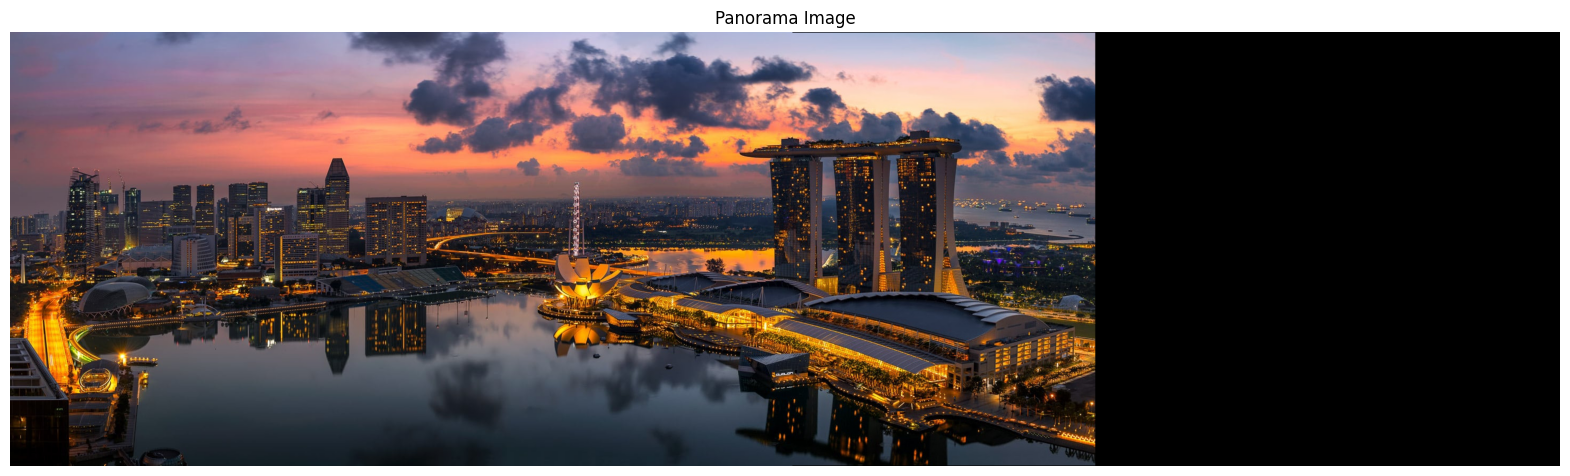

Panorama image saved to Output/output.jpg


In [57]:
width = train_image.shape[1] + query_image.shape[1]
height = max(train_image.shape[0], query_image.shape[0])
result = cv2.warpPerspective(train_image, Homography_matrix, (width, height))
print("Warped train image shape: ", result.shape)

result[0:query_image.shape[0], 0:query_image.shape[1]] = query_image
plt.figure(figsize=(20, 10))
plt.imshow(result)
plt.title('Panorama Image')
plt.axis('off')
plt.show()

# Save the stitched image to the output folder
output_path = "Output/{}".format(output_image_name)
cv2.imwrite(output_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
print(f"Panorama image saved to {output_path}")